# Problem Statement

Automate the process of assigning a label to keywords.

# Proposed Solution

With the help of labeled keywords data of past 5 years, we have tried to predict the label of new keywords using machine learning algorithms and natural language processing techniques.



Following is the breakdown of complete process:

1. Aggregating Raw Data : User search keywords of last 5 years were provided to us by marketing team with a label assigned to most of the keywords in a excel sheet. We used this data as our primary dataset for building a machine learning model.

2. Data Preprocessing: We cleaned the data before feeding it data to any model. We did multipkle things like removing missing values, converting url's to seperate words, etc in this stage.

3. Feature Engineering : We created two new features from the preprocessed dataset. Keyword column had charactes from multiple languages. Also many keywords with all english charactes had meaning in other languages. So, two new columns were created. First, to decide language on the basis of character and second on the basis of language.

4. Natural Language Processing ( Feature Vectors ) : We used feature vectors technique and converted each keyword into a feature vector of all the words present in all the keywords combined. After this step we had around 3500 columns in our dataset.

5. Selecting a model : We tried with three classifier's named as Logistic Regression Classifier, Random Forrest and Desicion Tree. After dividing the complete dataset into 10 parts and using cross validation, we got best mean accuracy of around 85% with Desicion Tree Classifier.

6. Prediction : We trained a desicion tree model on 95% of the dataset and used 5% of the dataset to test our model. We got an accuracy of 90% during this test.

Programming Language used : Python

Packages used : Pandas, Numpy, Scikit-Learn, NLTK

# Code and Results

1. Importing basic packages

In [2]:
# importing basic packages

import nltk
# python -m nltk.downloader all  ##type this on command line to download required nltk documents
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
os.chdir("D:/PlayGround/jupyter-nb/seo_keywords")

2. Loading data and aggregation.

In [2]:
df_init = pd.read_excel('Keyword Grouping & Sorting.xlsx')

In [55]:
df_init_2 = pd.read_excel('keyword_grouping.xlsx')

In [58]:
agg_df = df_init.append(df_init_2, ignore_index=True)

In [83]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13108 entries, 0 to 13107
Data columns (total 2 columns):
Keyword            13104 non-null object
Refined Keyword    9429 non-null object
dtypes: object(2)
memory usage: 204.9+ KB


In [60]:
df = agg_df.copy()

Dataset have 2 columns. Keyword and Refined Keyword. And 13108 rows. But labeled rows are 9429.

3. Some important fucntions which will be used later in the process

In [7]:
# function to add language feature

def add_lang_feat(dfi):
    dfi['non_eng'] = 0
    for index,row in dfi.iterrows():
        maxchar = max(row['Keyword'])
        if ord(maxchar)>127:
            dfi['non_eng'][index] = 1
    return dfi


In [8]:
# functions to split urls into words

def split_url(line):
    import re
    words = re.split('\:|\/|, |\.|\n|\>|\<|\-|\@',line)
    non_empty = []
    for word in words:
        if len(word)>0:
            non_empty.append(word)
    return ' '.join(non_empty)

def split_url_into_words(dfi):
    for index, row in dfi.iterrows():
        dfi['Keyword'][index] = split_url(str(row['Keyword']))
    return dfi
        


In [9]:
# function to detect language in the text and add a feature to df

def detect_lang(dfi):
    dfi['lang'] = 'en'
    from langdetect import detect
    for index, row in dfi.iterrows():
        try:
            dfi['lang'][index] = detect(row['Keyword'])
        except:
            print(row)
    return dfi
    

In [10]:
# separating df with only english characters

def eng_df(dfi):
    dfi = dfi[dfi['non_eng']==0]
    return dfi

In [61]:
# Global Count Feature Vector Object

from sklearn.feature_extraction.text import CountVectorizer
global_count_vect = CountVectorizer(analyzer='word')

In [12]:
# function to fit count feature vectors

def fit_count_vector(df_col):
    global_count_vect.fit(df_col)

In [13]:
# transform the data using count vectorizer object

def add_count_features(dfi):
    keyword_feature_matrix =  global_count_vect.transform(dfi['Keyword'])
    features = global_count_vect.get_feature_names()
    transformed_df = pd.DataFrame(keyword_feature_matrix.toarray(), columns = features)
    transformed_df['label'] = dfi['Refined Keyword'].tolist()
    transformed_df['Keyword'] = dfi['Keyword'].tolist()
    transformed_df['lang'] = dfi['lang'].tolist()
    return transformed_df

In [14]:
# function to convert categorial cols to integers with LabelEncoding

def label_encode(dfi, cat_cols):
    from sklearn import preprocessing
    for col in cat_cols:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(dfi[col].values.astype('str')))
        dfi[col] = lbl.transform(list(dfi[col].values.astype('str')))
    return dfi

# Preprocessing and Feature Engineering

4. Removing missing values.

In [62]:
# Step 1 : Remove NaN/Empty
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9429 entries, 77 to 13107
Data columns (total 2 columns):
Keyword            9429 non-null object
Refined Keyword    9429 non-null object
dtypes: object(2)
memory usage: 221.0+ KB


In [63]:
df['Refined Keyword'].nunique()

142

There are 142 Unique labels.

In [64]:
df['Refined Keyword'].value_counts()[-100:].sum()

187

Chart representing the frequency of all 142 labels.

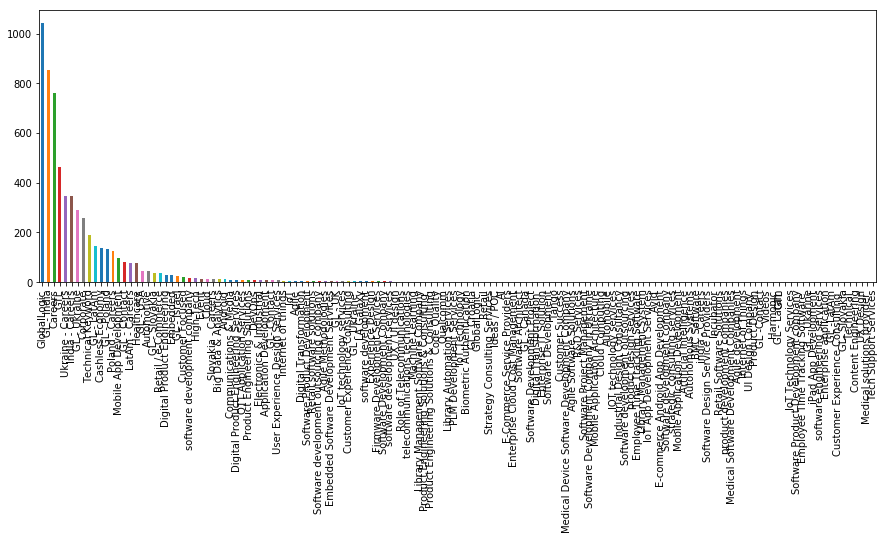

In [19]:
df['Refined Keyword'].value_counts().plot(kind = 'bar', figsize = (15,5))

5. Adding language feature

In [65]:
# Step 2 : Adding Language Feature
df = add_lang_feat(df)
df['non_eng'].value_counts()

0    8985
1     444
Name: non_eng, dtype: int64

6. Splitting urls and detecting languages in the text.

In [66]:
# Step 3 : Split urls in Keyword column to words
df = split_url_into_words(df)

# Step 4 : detect language in the text and add a feature to df
df = detect_lang(df)

df[:5]

,Keyword,Refined Keyword,non_eng,lang
77,1mobile market,Mobile App Development,0,tr
78,2 2 channel ukraine,GL - Ukraine,0,de
79,5 ETAPAS DE BPMN,Technical Keyword,0,de
80,5 ETAPAS DEL BPMN,Technical Keyword,0,de
81,5 g live mobile,Mobile App Development,0,sl


In [67]:
df['lang'].nunique()

41

There are 41 different languages used in the keywords. Below chart shows the frequency of all the languages.

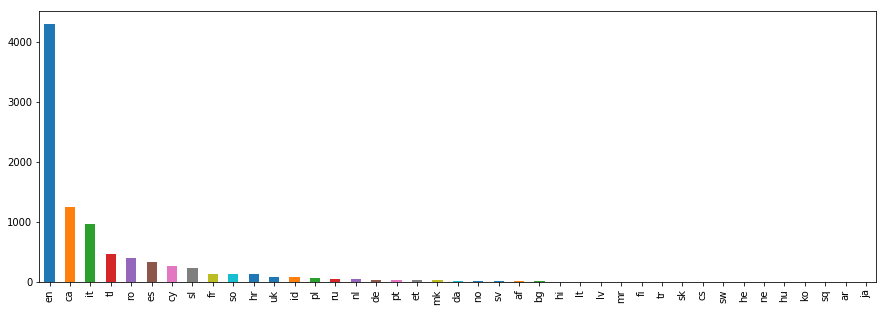

In [68]:
df['lang'].value_counts().plot(kind = 'bar', figsize = (15,5))

7. Seperating dataset with only english characters. (Note: languages will remain multiple)

In [69]:
# Step 5 : separating df with only english characters
df = eng_df(df)

In [70]:
# Step 6 : fit count feature vectors
fit_count_vector(df['Keyword'])

In [71]:
# Step 7 : Add count feature vectors to df
df = add_count_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Columns: 3553 entries, 003 to lang
dtypes: int64(3550), object(3)
memory usage: 243.6+ MB


In [72]:
# Step 8 : Label encoding categorial columns
df = label_encode(df, ['lang'])

In [73]:
other_classes = list(df['label'].value_counts()[-100:].index)

In [74]:
df_new = df.copy()

In [75]:
df_new['label'].replace(to_replace=other_classes, value = 'other', inplace=True)

In [76]:
df = df_new

In [77]:
df['label'].nunique()

39

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Columns: 3553 entries, 003 to lang
dtypes: int64(3551), object(2)
memory usage: 243.6+ MB


# Training Logistic Regression Classifier Model using Cross Validation

In [27]:
# custom cross validation function

def custom_cv(classifier_obj, X, y, split=5):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(classifier_obj, X, y, cv=split)
    print(scores)
    return scores.mean()

In [79]:
from sklearn.linear_model import LogisticRegression
x_col = list(set(list(df)) - set(['label', 'Keyword']))
y_col = ['label']
accuracy_lc = custom_cv(LogisticRegression(), df[x_col], df[y_col], split=10)
print(accuracy_lc)

[0.77461707 0.75109649 0.78327833 0.83664459 0.81616833 0.78619154
 0.79910213 0.88863892 0.89253394 0.90102389]
0.822929522305761


Accuracy of Linear Model : 82.29%

# Training Random Forest Classifier Model using Cross Validation

In [81]:
from sklearn.ensemble import RandomForestClassifier
accuracy_rf = custom_cv(RandomForestClassifier(), df[x_col], df[y_col], split=10)
print(accuracy_rf)

[0.87089716 0.7752193  0.74037404 0.83774834 0.78405316 0.79510022
 0.85521886 0.8920135  0.94230769 0.95904437]
0.8451976628684535


Accuarcy of Random Forest Model : 84.51%

# Training Decision Tree Classifier Model using Cross Validation

In [80]:
from sklearn.tree import DecisionTreeClassifier
accuracy_dt = custom_cv(DecisionTreeClassifier(), df[x_col], df[y_col], split=10)
print(accuracy_dt)

[0.88621444 0.78837719 0.75577558 0.85320088 0.76744186 0.77505568
 0.8630752  0.90326209 0.94909502 0.95904437]
0.8500542315180086


Accuarcy of Decision Tree Model (Mean) : 85.00%

Accuarcy varied from 75% to 96%. Below chart shows the accuracy of decision tree model on 10 different splits of dataset.


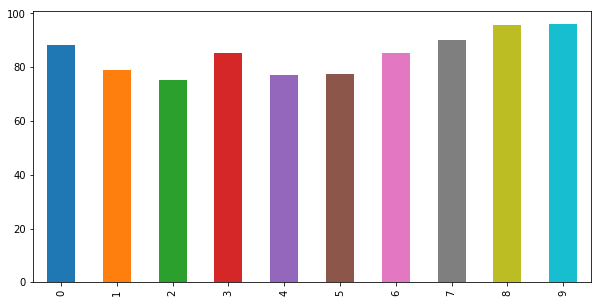

In [120]:
df_acc['accuracy'].plot(kind='bar', figsize = (10,5))

# Seperating Training and Test data for Prediction

In [98]:
df_demo = df
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Columns: 3553 entries, 003 to lang
dtypes: int64(3551), object(2)
memory usage: 243.6+ MB


In [99]:
import numpy as np
indices = np.random.rand(len(df_demo)) <= 0.05
df_demo = df_demo[indices]
df_demo.to_csv('demo_pp.csv', index=False)

In [100]:
df_demo_actual = df_demo[['Keyword', 'label']]

In [101]:
df_demo_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449 entries, 9 to 8960
Data columns (total 2 columns):
Keyword    449 non-null object
label      449 non-null object
dtypes: object(2)
memory usage: 10.5+ KB


In [102]:
df_demo_actual.to_csv('demo_actual.csv', index=False)

In [103]:
training_df = df
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Columns: 3553 entries, 003 to lang
dtypes: int64(3551), object(2)
memory usage: 243.6+ MB


In [104]:
training_df = training_df[~indices]
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8536 entries, 0 to 8984
Columns: 3553 entries, 003 to lang
dtypes: int64(3551), object(2)
memory usage: 231.5+ MB


In [105]:
training_df.to_csv('training_pp.csv', index=False)
training_df_actual = training_df[['Keyword', 'label']]
training_df_actual.to_csv('training_actual.csv', index=False)

# Training Decision Tree Classifier and Predicting on Test Data 

In [108]:
from sklearn.tree import DecisionTreeClassifier
x_cols = list(set(list(df)) - set(['label', 'Keyword']))
y_cols = ['label']
accuracy_dt = custom_cv_2(DecisionTreeClassifier(), df[x_col], df[y_col], split=10)

In [107]:
def custom_cv_2(classifier_obj, X, y, split=5):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(classifier_obj, X, y, cv=split)
    return scores

In [111]:
df_acc = pd.DataFrame(accuracy_dt, columns=['accuracy'])

In [114]:
df_acc['accuracy'] = df_acc['accuracy']*100

In [121]:
df_acc['accuracy'].describe()

count    10.000000
mean     84.984604
std       7.672129
min      75.247525
25%      77.922125
50%      85.363941
75%      89.760949
max      96.245734
Name: accuracy, dtype: float64

In [122]:
# Training on pp training data

In [123]:
train_df = pd.read_csv('training_pp.csv')
test_df = pd.read_csv('demo_pp.csv')

In [124]:
dt_model = DecisionTreeClassifier().fit(train_df[x_cols],train_df[y_cols] )

In [125]:
predictions = dt_model.predict(test_df[x_cols])

In [126]:
results_df = test_df[['Keyword','label']]
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 2 columns):
Keyword    449 non-null object
label      449 non-null object
dtypes: object(2)
memory usage: 7.1+ KB


In [127]:
results_df['predicted'] = predictions

In [129]:
from sklearn.metrics import accuracy_score
accuracy_score(results_df['label'], results_df['predicted'])

0.9064587973273942

In [128]:
results_df[:5]

,Keyword,label,predicted
0,2018 healthcare industry packaging trends,Healthcare,Healthcare
1,Net+WPF+C#+lviv+developer+,Careers,Careers
2,logic' named related company in bhopal,GlobalLogic,GlobalLogic
3,A Global UI Design Company,other,other
4,about global logic in hyderabad,GTL,GTL


In [130]:
results_df.to_csv('results_new.csv', index=False)

In [147]:
results_df['correctly_predicted'] = 'False'

In [150]:
final_df = results_df.copy()

In [151]:
for index, row in final_df.iterrows():
    if row['label']==row['predicted']:
        final_df['correctly_predicted'][index] = 'True'

In [155]:
final_df[final_df['correctly_predicted']=='False'].shape

(42, 4)

In [156]:
final_df.to_csv('final_results.csv', index=False)

In [132]:
other_classes[:5]

['Digital Product Engineering Services',
 'Product Engineering Solutions',
 'IoT',
 'User Experience Design Services',
 'GL- Contact']

In [133]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13108 entries, 0 to 13107
Data columns (total 2 columns):
Keyword            13104 non-null object
Refined Keyword    9429 non-null object
dtypes: object(2)
memory usage: 204.9+ KB


In [134]:
agg_df['Refined Keyword'].nunique()

142

In [158]:
agg_df['Refined Keyword'].value_counts()[-100:].sum()

187

In [144]:
df['label'].nunique()

39

In [146]:
df['label'].value_counts().describe()

count      39.000000
mean      230.384615
std       359.631508
min        10.000000
25%        24.000000
50%        66.000000
75%       216.000000
max      1395.000000
Name: label, dtype: float64

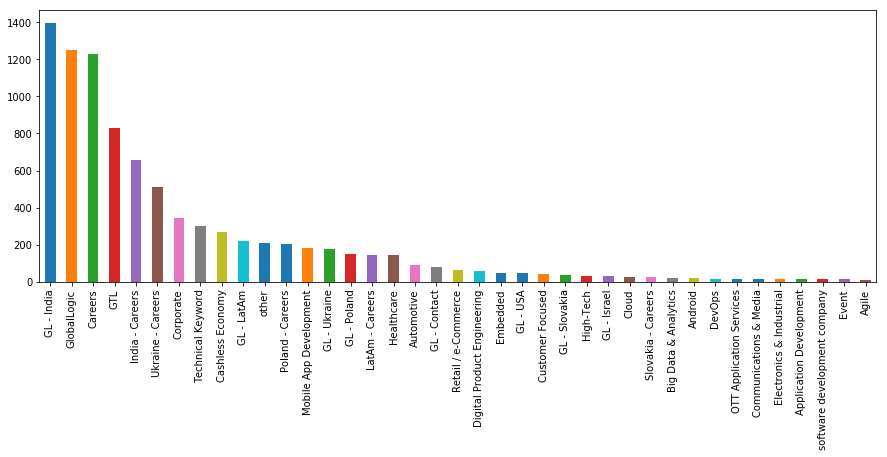

In [143]:
df['label'].value_counts().plot(kind = 'bar', figsize = (15,5))